# Toy model: loss function and Bayesian sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Basic functions

- compute_single (as a class)
- compute

In [97]:
class compute_single:

    """
    Compute basic quantities.

    Parameters
    ---------------
    lambda_i: array_like
        some values for $\lambda$ variable (for example `lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)`)
    
    P0: array_like
        the reference ensemble $P_0(x)$
    
    g: array_like
        the observable $g(x)$
    
    g_exp: array_like
        its experimental value $g_{exp}$ and error $\sigma_{exp}$
    
    alpha: float
        the alpha hyperparameter

    ---------------
    
    Returns
    ---------------
    P
        the new probability distributions $P_\lambda(x)$
    
    Z
        the new partition functions $Z_\lambda$
    
    av_g
        the average value of the observable $\langle g\rangle_\lambda$ (as a function of $\lambda$)
    
    av_g2

    std_g
        the standard deviation of the observable $\sigma(\lambda)$ (which is the "volume transformation")
    
    chi2
        the $\chi^2(\lambda)$
    
    Srel
        the relative entropy $S[P_\lambda|P_0]$
    
    lossf
        the values of loss function $\mathcal L(\lambda)$"""

    def __init__(self, lambda_i, P0, g, gexp, sigma, alpha):

        self.P = P0*np.exp(-lambda_i*g)
        self.Z = [np.sum(self.P)]
        self.P = self.P/self.Z

        self.av_g = np.dot(self.P, g)
        self.av_g2 = np.dot(self.P, g**2)
        self.std_g = np.sqrt(self.av_g2 - self.av_g**2)
        
        self.chi2 = ((self.av_g - gexp)/sigma)**2
        # chi2.append((np.maximum(av_g-gexp,0)/sigma)**2)
        self.Srel = np.log(self.Z) + lambda_i*self.av_g
        self.lossf = 1/2*self.chi2 - alpha*self.Srel

In [98]:
def compute(lambdas, P0, g, gexp, sigma, alpha):
    """
    stack `compute_single` results and include the "volume transformation" for the Dirichlet prior
    and also the values of Gamma function $\Gamma(\lambda)$ 
    """

    results = []

    for lambda_i in lambdas:

        out = compute_single(lambda_i, P0, g, gexp, sigma, alpha)
        results.append(vars(out))

        results[-1]['dirichlet'] = 1/2*np.sqrt(np.abs(np.dot(out.P**2, (out.av_g*np.ones(len(out.P)) - g)**2)))
    
    # rearrange as a single dict (namely, invert the two indices of results)
    results_dict = {}

    for s in results[0].keys():
        results_dict[s] = np.array([results[i][s][0] for i in range(len(results))])
    
    results_dict['gamma'] = alpha*(np.log(results_dict['Z']) + lambdas*gexp + 1/2*alpha*(sigma*lambdas)**2)

    # del results

    return results_dict

## Example

In [2]:
alpha = 1

### some Dirac deltas

In [3]:
n = 2 # number of points

# probability distribution:
p0 = [3/4,1/4]

# normalize, if not normalized
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([0, 1])

# experimental value and error of the observable
gexp = 0.9
sigma = 0.2

In [4]:
dlambda = 1e-1
lambdamax = 25
lambdas = np.arange(-lambdamax-dlambda,lambdamax+dlambda,dlambda)

### or more Dirac deltas, so random generation of values

In [99]:
n = 80

In [100]:
#g=np.concatenate((np.random.normal(0,size=np.int(N/2)),np.random.normal(1,size=np.int(N/2))))
g = np.random.normal(1, 0.5, size=n)
gexp = 2
sigma = 0.5

p0 = np.random.dirichlet(np.ones(n), size=1)

lambdamax = 100

dlambda = 0.01
# lambdas = np.arange(- lambdamax - dlambda, lambdamax + dlambda, dlambda)

lambdas = np.linspace(- lambdamax, lambdamax, n)

Text(0.5, 0, 'n frames')

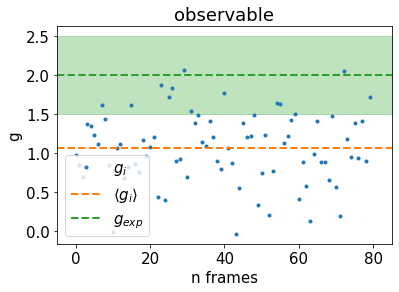

In [101]:
plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

## compute and plot

In [102]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

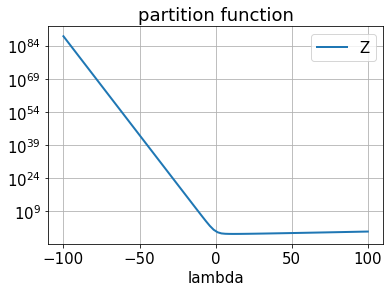

In [103]:
plt.plot(lambdas, results['Z'], '-', label='Z')
plt.yscale('log')
plt.xlabel('lambda')
plt.title('partition function')
plt.legend()
plt.grid()

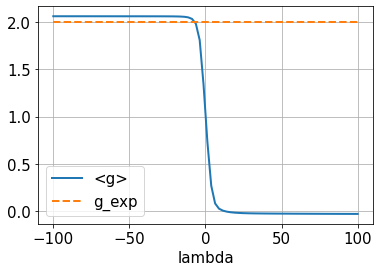

In [104]:
plt.plot(lambdas, results['av_g'], '-', label='<g>')
plt.plot([lambdas[0], lambdas[-1]], [gexp, gexp], '--', label='g_exp')
#plt.yscale('log')
plt.xlabel('lambda')
plt.legend()
plt.grid()

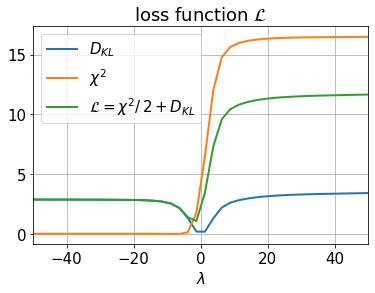

In [108]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2

plt.plot(lambdas, -results['Srel'], '-', label=r'$D_{KL}$')
plt.plot(lambdas, results['chi2'], '-', label=r'$\chi^2$')
plt.plot(lambdas, -results['Srel'] + 1/2*results['chi2'], '-', label=r'$\mathcal{L}=\chi^2/\,2+D_{KL}$')

plt.title(r'loss function $\mathcal{L}$')
#plt.yscale('log')
plt.xlim([-50, 50])
plt.xlabel(r'$\lambda$')
plt.legend()
plt.grid()


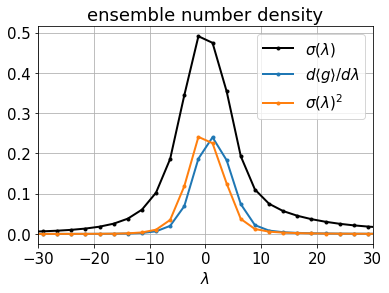

In [117]:
#plt.plot(lambdas,-np.log(std_gs),'-',label='- log std')

plt.plot(lambdas, results['std_g'], '.-', label=r'$\sigma(\lambda)$', c='k')
#plt.plot(lambdas,-2*np.log(std_gs),'-',label='- log variance')
#plt.plot(lambdas,-np.log(dirichlets),'-',label='equiv. for Dirichlet')

plt.plot(lambdas[1:], np.abs(np.ediff1d(results['av_g'])/np.ediff1d(lambdas)), '.-', label=r'$d\langle g\rangle/d\lambda$')
plt.plot(lambdas, results['std_g']**2, '.-', label=r'$\sigma(\lambda)^2$')

plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
#plt.title('volume transformation')
plt.xlim([-30, 30])
plt.title('ensemble number density')
plt.show()

So we could say it is quite the same to use $\sigma d\lambda$ or $\sigma^2 d\lambda$, corresponding to measuring distances with Fisher metrics (namely, Jeffreys prior, KL divergence) or with $d\langle g \rangle$, respectively. However, there is the issue of dimensions: are there more ensembles in between 1 and 2 $\mu m$ or in between 1 and 2 $Hz$? It makes no sense, so let's use $\sigma d\lambda$ which is adimensional.

In [119]:
results['lossf']

array([ 2.9108997 ,  2.90919951,  2.90750413,  2.90581487,  2.90413306,
        2.90246011,  2.90079746,  2.89914662,  2.89750912,  2.89588653,
        2.89428047,  2.89269255,  2.89112438,  2.8895775 ,  2.88805337,
        2.88655321,  2.8850779 ,  2.88362772,  2.88220205,  2.88079875,
        2.87941339,  2.87803795,  2.87665877,  2.87525352,  2.87378637,
        2.87220041,  2.87040571,  2.86825991,  2.86553592,  2.86186592,
        2.85663824,  2.84879298,  2.83637997,  2.81551349,  2.7777069 ,
        2.7027511 ,  2.53981437,  2.16480735,  1.39750088,  1.07642515,
        3.41714112,  7.31743572,  9.58884729, 10.42574738, 10.80015407,
       11.02145201, 11.1720393 , 11.28014915, 11.35958782, 11.41894159,
       11.46411979, 11.49931693, 11.52752572, 11.55087528, 11.57087278,
       11.58857908, 11.60473629, 11.61985965, 11.6343035 , 11.64830827,
       11.66203402, 11.67558426, 11.68902287, 11.7023861 , 11.71569118,
       11.72894234, 11.74213511, 11.75525941, 11.76830172, 11.78

In [125]:
loss = results['lossf']
loss -= np.min(loss)

loss1 = loss - np.log(results['std_g'])
loss1 -= np.min(loss1)

loss2 = loss - 2*np.log(results['std_g'])
loss2 -= np.min(loss2)

gamma = results['gamma']

loss_dir = loss - np.log(results['dirichlet'])

delta = np.min(loss) - np.min(gamma)

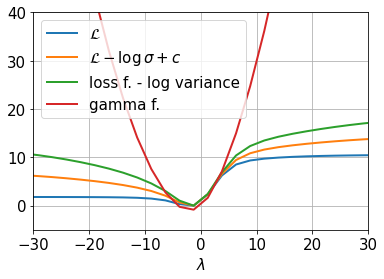

In [126]:
plt.plot(lambdas, loss, '-', label=r'$\mathcal{L}$')#loss f.')#,markersize=0.5)
plt.plot(lambdas, loss1, '-', label=r'$\mathcal{L}-\log\sigma+c$')
#plt.plot(lambdas,-loss+loss1,'-',label=r'$-\log\sigma$')

plt.plot(lambdas, loss2, '-', label='loss f. - log variance')
plt.plot(lambdas, gamma, '-', label='gamma f.')
#plt.plot(lambdas,gamma+delta,'-',label='gamma f. +delta')
#plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\lambda$')
#plt.yscale('log')
plt.xlim([-30, 30])
plt.ylim([-5,40])
plt.grid()

In [127]:
xmin_loss = lambdas[np.argwhere(loss == np.min(loss))[0][0]]
xmin_gamma = lambdas[np.argwhere(gamma == np.min(gamma))[0][0]]
xmin_1 = lambdas[np.argwhere(loss1 == np.min(loss1))[0][0]]
xmin_2 = lambdas[np.argwhere(loss2 == np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ', xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)


min. of the "original" loss function:  -1.2658227848101262
min. of Gamma function:  -1.2658227848101262
min. of the loss f. with std correction:  -1.2658227848101262
min. of the loss f. with variance correction:  -1.2658227848101262


so, the hyper probability distribution $P(\lambda)$ is:

In [128]:
hyper_P0 = np.exp(-loss)
hyper_P1 = np.exp(-loss1)
hyper_P2 = np.exp(-loss2)
hyper_P_gamma = np.exp(-gamma)
hyper_P_dir = np.exp(-loss_dir)

In [130]:
hyper_P0.shape

(80,)

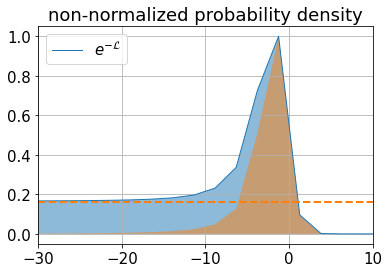

In [133]:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 15

plt.plot(lambdas, hyper_P0, label=r'$e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
#plt.plot(lambdas,hyper_P_gamma,label='gamma')

#plt.plot(lambdas,hyper_P1,label=r'$\sigma \, e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P1, alpha=0.5)

#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
plt.xlim([-30, 10])
plt.plot([-30, 10], [hyper_P0[0], hyper_P0[0]], '--', linewidth=2)
#plt.yscale('log')
plt.grid()
plt.title('non-normalized probability density')
plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))

In [134]:
hyper_P0 = hyper_P0/np.sum(hyper_P0)
hyper_P1 = hyper_P1/np.sum(hyper_P1)
hyper_P2 = hyper_P2/np.sum(hyper_P2)
hyper_P_gamma = hyper_P_gamma/np.sum(hyper_P_gamma)
hyper_P_dir = hyper_P_dir/np.sum(hyper_P_dir)

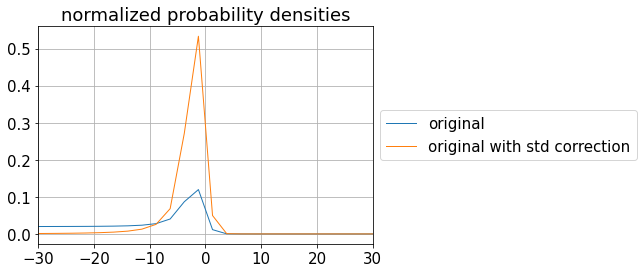

In [135]:
plt.plot(lambdas, hyper_P0, label='original')
#plt.plot(lambdas,hyper_P_gamma,label='gamma')
plt.plot(lambdas, hyper_P1, label='original with std correction')
#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
plt.xlim([-30, 30])
#plt.yscale('log')
plt.grid()
plt.title('normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Metropolis sampling

In [23]:
# choice=0 Jeffreys, 1 BELT, 2 BELT modified (averages)
def Metropolis_sampling(delta=0.5,nsteps=100,phi0=0,choice=0): # z0=1

    #rng=np.random.default_rng(seed=0)

    traj=[]
    time=[]
    avaccept=0
    energies=[]

    #phi=minphis+np.random.normal(minphis,1,size=1)*z0
    phi=phi0

    traj.append(phi)
    time.append(0)

    out=compute_single(phi,P0,g,gexp,sigma,alpha)
    
    #out=-np.exp(-phi**2) # sample a gaussian-like (i.e. with minimum but not bounded) potential
    if choice==0: energy=out[6]-np.log(out[3])
    elif choice==1: energy=out[6]
    elif choice==2: energy=out[6]-2*np.log(out[3])

    energies.append(energy)

    for istep in range(nsteps):
        #delta=0.1
        # better, different deltas for different coordinates, estimated with the covariance at MAP
        #delta=0.1*np.sqrt(np.diag(goodcov))
        #phitry=trial(phi,delta=delta)
        phitry=phi+(2*np.random.rand()-1)*delta

        
        out=compute_single(phitry,P0,g,gexp,sigma,alpha)
        if choice==0: energy_try=out[6]-np.log(out[3])
        elif choice==1: energy_try=out[6]
        elif choice==2: energy_try=out[6]-2*np.log(out[3])
        #print(lossf_try)

        accept=np.exp(energy-energy_try)
        
        if accept>1: accept=1
        if accept>np.random.rand():
            avaccept+=1
            phi=+phitry
            energy=+energy_try

        traj.append(phi)
        time.append(istep+1)
        energies.append(energy)

    avaccept=avaccept/nsteps
    

    return np.array(time),np.array(traj),avaccept,energies




In [101]:
time,traj,avalpha,lossf=Metropolis_sampling(nsteps=1000000,phi0=0,choice=0) # JEFFREYS

In [102]:
time2,traj2,avalpha2,lossf2=Metropolis_sampling(nsteps=1000000,phi0=0,choice=1) # BELT

/tmp/ipykernel_3217/1671233481.py:9: RuntimeWarning: invalid value encountered in sqrt
  std_g=np.sqrt(av_g2-av_g**2)


In [ ]:
time3,traj3,avalpha3,lossf3=Metropolis_sampling(nsteps=1000000,phi0=0,choice=2) # BELT 2 (averages)

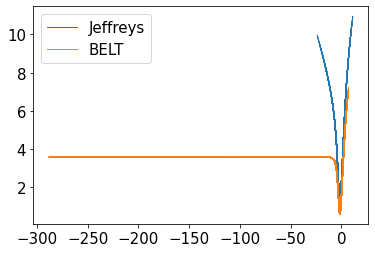

In [103]:
upto=1000000
plt.plot(traj[:upto],lossf[:upto],'-',label='Jeffreys')
plt.plot(traj2[:upto],lossf2[:upto],'-',label='BELT')
#plt.plot(traj3,lossf3,'-',label='BELT 2 (averages)')

plt.legend()

(0.0, 1000000.0)

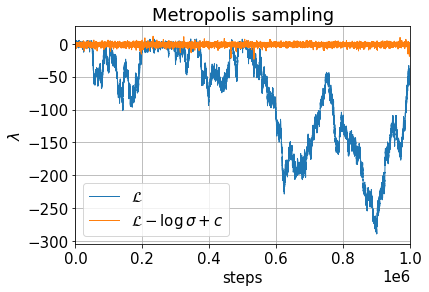

In [108]:
plt.rcParams['font.size']=15

plt.plot(time2[:upto],traj2[:upto],'-',label=r'$\mathcal{L}$',linewidth=1) # label='BELT' r'$dn=d\lambda$'
plt.plot(time[:upto],traj[:upto],'-',label=r'$\mathcal{L}-\log\sigma+c$',linewidth=1) # label='with Jeffreys prior" r'$dn=\sigma (\lambda) \, d\lambda$'

#plt.plot(time3,traj3,'-',label='BELT 2 (averages)')

plt.grid()
plt.legend(loc='lower left')
plt.title('Metropolis sampling')
plt.xlabel('steps')
plt.ylabel(r'$\lambda$')
#plt.ylim([-10,5])
plt.xlim([0,upto])

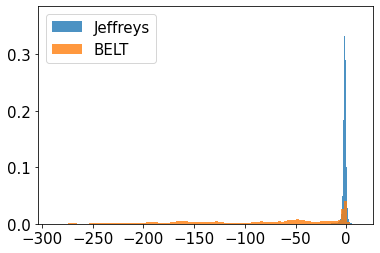

In [105]:
plt.hist(traj,bins=100,alpha=0.8,density=True,label='Jeffreys')

#plt.figure()
plt.hist(traj2,bins=100,alpha=0.8,density=True,label='BELT')
#plt.hist(traj3,bins=100)

plt.legend()

## Giovanni's trials:
- invariance w.r.t. number of frames
- data incompatible with trajectory

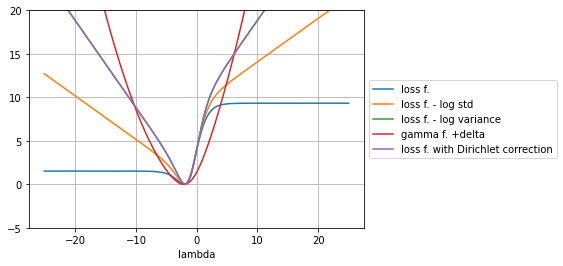

In [10]:
N=1
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

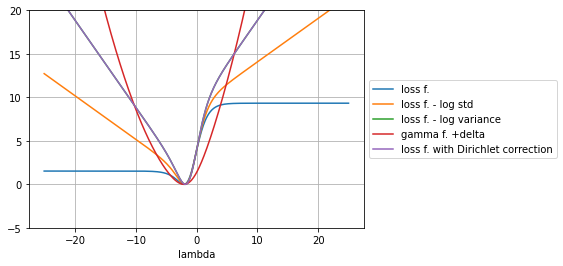

In [11]:
# invariance wrt number of frames:
N=1000
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

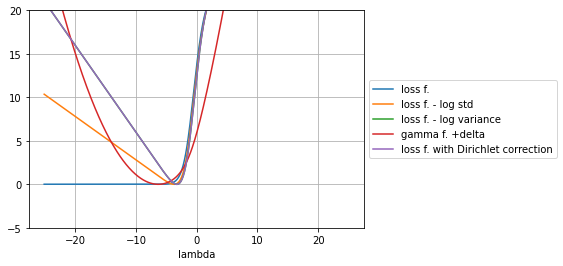

In [20]:
# data incompatible with trajectory
N=1
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=1.5



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)



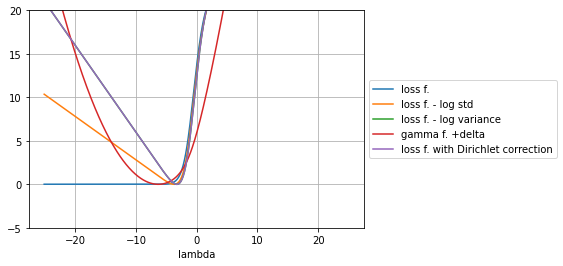

In [23]:
plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

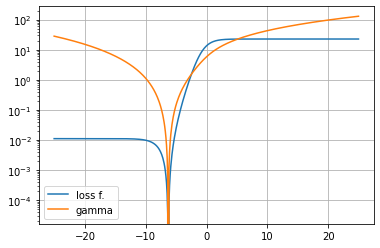

In [29]:
plt.plot(lambdas,loss,label='loss f.')
plt.plot(lambdas,gamma,label='gamma')
plt.yscale('log')
plt.legend()
plt.grid()


In [21]:
xmin_loss=lambdas[np.argwhere(loss==np.min(loss))[0][0]]
xmin_gamma=lambdas[np.argwhere(gamma==np.min(gamma))[0][0]]
xmin_1=lambdas[np.argwhere(loss1==np.min(loss1))[0][0]]
xmin_2=lambdas[np.argwhere(loss2==np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ',xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)

min. of the "original" loss function:  -6.299999999999734
min. of Gamma function:  -6.299999999999734
min. of the loss f. with std correction:  -3.6999999999996973
min. of the loss f. with variance correction:  -3.2999999999996916


### coarse graining

In [50]:

P0s=[np.array([1/3, 2/3]),np.array([1/3, 1/3, 1/3]),np.array([1/3, 0, 2/3])] # normalized
g2p=np.array([1,2])
g3p=np.array([1,2,2])
gs=[g2p,g3p,g3p]

gexp=0.9

In [51]:
Srels=[]
for i in range(len(P0s)):
    Srels.append(compute(lambdas,P0s[i],gs[i],gexp,sigma,alpha)[6])

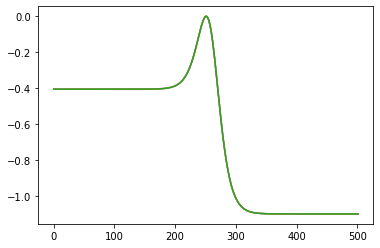

In [52]:
for Srel in Srels:
    plt.plot(Srel,'-')